# Encoder와 Decoder의 구조가 같은 오토인코더로 이상치 탐지

In [1]:
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns

In [3]:
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model

df = pd.read_csv("C:/Users/Administrator/dataset/DSA_features.csv")
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [7]:
# Null값 확인
df.isna().values.any()

False

In [9]:
np.unique(df['activity'], return_counts=True)

(array(['ascendingStairs', 'basketBall', 'crossTrainer',
        'cyclingHorizontal', 'cyclingVertical', 'decendingStairs',
        'jumping', 'lyingBack', 'lyingRigh', 'movingInElevator', 'rowing',
        'runningTreadmill', 'sitting', 'standing',
        'standingInElevatorStill', 'stepper', 'walkingLot',
        'walkingTreadmillFlat', 'walkingTreadmillIncline'], dtype=object),
 array([480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480,
        480, 480, 480, 480, 480, 480], dtype=int64))

In [17]:
# 필요한 데이터 필터링 (Lying = 정상, Sitting = 비정상)
df = df.loc[df['activity'].isin(['lyingRigh', 'lyingBack', 'jumping'])]
df['class'] = df['activity'].apply(lambda x: 'normal' if x.startswith('lying') else 'abnormal')

In [21]:
# 정상(normal) 데이터: lying 관련 활동
normal = df[df.activity.isin(['lyingRigh', 'lyingBack'])]

# 비정상(abnormal) 데이터: sitting
abnormal = df[df.activity == 'sitting']

In [23]:
# 특성과 레이블 정의
X_train = normal.drop(['activity', 'people'], axis=1)
X_mix = df.iloc[:, :-1].drop(['activity', 'people'], axis=1)
y_mix = df['class'].apply(lambda x: 0 if x == 'abnormal' else 1)

In [29]:
# 'activity'와 'class' 컬럼을 제외한 숫자형 컬럼만 선택
X_train = normal.drop(['activity', 'class', 'people'], axis=1)

In [31]:
# 데이터 정규화
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_mix = ss.transform(X_mix)

In [35]:
# 데이터프레임의 컬럼 확인
print(df.columns)

# 'class' 컬럼이 존재한다면 제거
X_mix = df.iloc[:, :-1].drop(['activity', 'people'], axis=1)  # 'class' 컬럼이 없다면 제거하지 않음
X_mix_scaled = ss.transform(X_mix)


Index(['T_xacc_mean', 'T_xacc_max', 'T_xacc_min', 'T_xacc_var', 'T_xacc_std',
       'T_xacc_skew', 'T_yacc_mean', 'T_yacc_max', 'T_yacc_min', 'T_yacc_var',
       ...
       'LL_ymag_skew', 'LL_zmag_mean', 'LL_zmag_max', 'LL_zmag_min',
       'LL_zmag_var', 'LL_zmag_std', 'LL_zmag_skew', 'activity', 'people',
       'class'],
      dtype='object', length=273)


In [37]:
# Linear Encoder 모델 생성
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [39]:
# 입력 차원 설정
input_dim = X_train.shape[1]

# AE 모델 정의 (Linear Encoder & Decoder)
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
bottleneck = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(bottleneck)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# 모델 인스턴스 생성
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
autoencoder.compile(optimizer=Adam(), loss='mse')

# 모델 요약
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)     │ (None, 270)           │            0 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                │ (None, 128)           │       34,688 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense_1 (Dense)              │ (None, 64)            │        8,256 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense_2 (Dense)              │ (None, 32)            │        2,080 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense_3 (Dense)              │ (None, 16)            │          528 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense_4 (Dense)              │ (None, 32)            │          544 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense_5 (Dense)              │ (None, 64)            │        2,112 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense_6 (Dense)              │ (None, 128)           │        8,320 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense_7 (Dense)              │ (None, 270)           │       34,830 │
└──────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 91,358 (356.87 KB)

 Trainable params: 91,358 (356.87 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# 모델 훈련
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = autoencoder.fit(X_train, X_train, 
                          epochs=50, 
                          batch_size=32, 
                          shuffle=True, 
                          callbacks=[early_stopping_cb],
                          validation_split=0.1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 1.3944 - val_loss: 0.6539
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9418 - val_loss: 0.6488
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8528 - val_loss: 0.6453
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8195 - val_loss: 0.6421
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9704 - val_loss: 0.6427
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9631 - val_loss: 0.6357
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9220 - val_loss: 0.6274
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8521 - val_loss: 0.6262
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9361 - val_loss: 0.6182
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8277 - val_loss: 0.6132
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9845 - val_loss: 0.5963
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8720 - val_

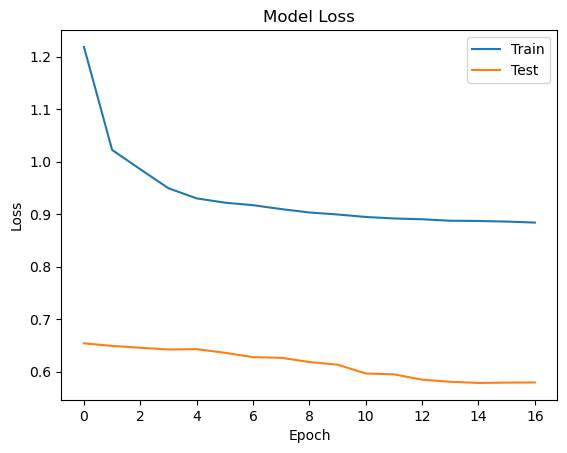

In [43]:
# 훈련 및 검증 손실 시각화
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [45]:
# 예측 및 재구성 오차 계산
predictions = autoencoder.predict(X_mix)
mse = np.mean(np.abs(X_mix - predictions), axis=1)

# 재구성 오차와 실제 레이블 데이터프레임 생성
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_mix})

error_df.describe()

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,reconstruction_error,true_class
count,1440.000000,1440.000000
mean,2.633639,0.666667
std,2.844117,0.471568
min,0.739652,0.000000
25%,0.841226,0.000000
50%,0.879544,1.000000
75%,4.273232,1.000000
max,15.867091,1.000000


In [47]:
error_df.head()

,reconstruction_error,true_class
960,0.801571,1
961,0.804751,1
962,0.792637,1
963,0.812976,1
964,0.801390,1


In [49]:
threshold = 0.7

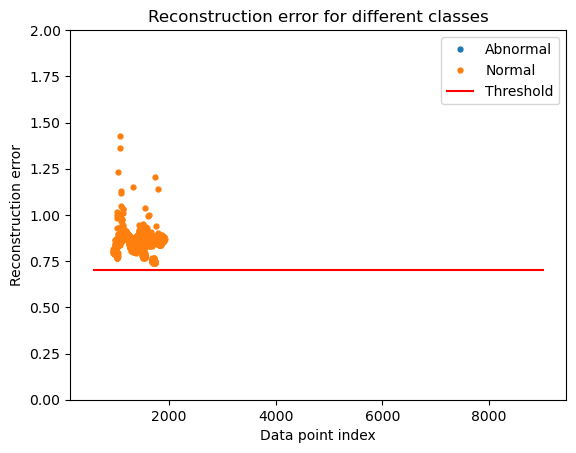

In [51]:
import matplotlib.pyplot as plt
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
ax.set_ylim(0, 2)

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnormal" if name == 0 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

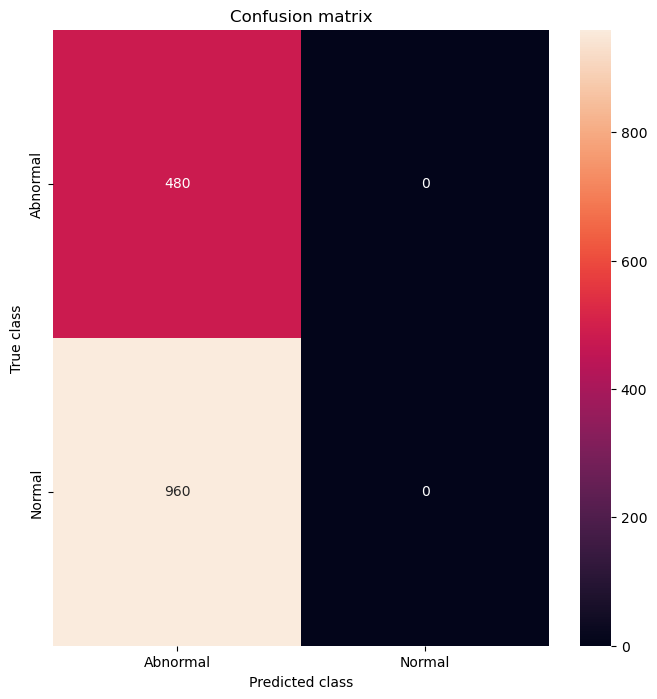

              precision    recall  f1-score   support

           0       0.33      1.00      0.50       480
           1       0.00      0.00      0.00       960

    accuracy                           0.33      1440
   macro avg       0.17      0.50      0.25      1440
weighted avg       0.11      0.33      0.17      1440



C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=['Abnormal', 'Normal'], yticklabels=['Abnormal', 'Normal'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred))